# BYOMBM Part 1: PBMetaD & FPS

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib agg

In [2]:
%run Imports.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setup

In [12]:
definition_my_fragment = read_fragment_definition(definitions.file("fragment_NH4+.def"))
definition_water = read_fragment_definition(definitions.file("H2O.def"))

definition_monomer = BasicCompoundDefinition()
definition_monomer.add_fragment(definition_my_fragment)
write_definition(definitions.file("monomer.xyz"), definition_monomer)

definition_monomer_H2O = BasicCompoundDefinition()
definition_monomer_H2O.add_fragment(definition_water)
write_definition(definitions.file("monomer_H2O.xyz"), definition_monomer_H2O)

definition_dimer = BasicCompoundDefinition()
definition_dimer.add_fragment(definition_my_fragment)
definition_dimer.add_fragment(definition_water)
write_definition(definitions.file("dimer.xyz"), definition_dimer)

definition_trimer = BasicCompoundDefinition()
definition_trimer.add_fragment(definition_my_fragment)
definition_trimer.add_fragment(definition_water)
definition_trimer.add_fragment(definition_water)
write_definition(definitions.file("trimer.xyz"), definition_trimer)

In [4]:
system_initializer = VSEPRInitializer(seed=12345)

In [5]:
init_monomer = system_initializer(definition_monomer)
write_system(structures.file("initialized_monomer.xyz"), init_monomer)

Initializing compound N1H4
System initialization complete!


In [6]:
calculator = Psi4Calculator(
        "HF",
        "STO-3G",
        log_directory=str(logs),
        scratch_directory="scratch",
        qm_options={
            "GEOM_MAXITER": 500
        }
)

In [7]:
optimized_monomer, optimized_e, log_path = calculator.optimize(
        init_monomer,
        num_threads=16,
        mem_mb=16000
)

Optimizer: Optimization complete!


In [8]:
write_system(structures.file("optimized_monomer.xyz"), optimized_monomer)

In [9]:
modes_monomer, log_path = calculator.normal_modes(
        optimized_monomer,
        num_threads=16,
        mem_mb=16000
)

In [10]:
write_vibrational_modes(structures.file("modes_monomer.modes"), modes_monomer)

In [13]:
optimized_water = read_system(definitions.file("monomer_H2O.xyz"), structures.file("water.xyz"))

In [22]:
clusters_dimer = find_clusters(
        [optimized_monomer, optimized_water],
        calculator=calculator,
        num_guesses=1,
        restart_path=restart.sub_directory("clusters_2b"),
        guess_seed=123345,
        radius=5,
        num_threads=16,
        mem_mb=32000,
        similarity_threshold=0.1,
        filter_by_hbonds=True,
        hbond_cut=3.0
)

Distance Distribution: dist (A) = 5.0 * x + 0.0 for x in range [0,1].
Beginning random distance and rotation configuration generation.
Will generate 1 configs with distance distribution dist (A) = 5.0 * x + 0.0 for x in range [0,1].
Done! Generated 1 configurations.
Minimizing geometries:  |====================================================================================================| - 1/1
Completed geometry minimizations!
Finding unique clusters:  |====================================================================================================| - 1/1
Found 1 unique minimized clusters.


In [23]:
optimized_dimer = clusters_dimer[0]

In [24]:
write_system(structures.file("optimized_dimer.xyz"), optimized_dimer)

In [19]:
modes_dimer, log_path = calculator.normal_modes(
        optimized_dimer,
        num_threads=16,
        mem_mb=16000
)

In [20]:
write_vibrational_modes(structures.file("modes_dimer.modes"), modes_dimer)

In [25]:
clusters_trimer = find_clusters(
        [optimized_monomer, optimized_water, optimized_water],
        calculator=calculator,
        num_guesses=1,
        restart_path=restart.sub_directory("clusters_3b"),
        guess_seed=123345,
        radius=5,
        num_threads=16,
        mem_mb=32000,
        similarity_threshold=0.1,
        filter_by_hbonds=True,
        hbond_cut=3.0
)

Distance Distribution: dist (A) = 5.0 * x + 0.0 for x in range [0,1].
Beginning random distance and rotation configuration generation.
Will generate 1 configs with distance distribution dist (A) = 5.0 * x + 0.0 for x in range [0,1].
Done! Generated 1 configurations.
Optimizer: Optimization complete!                                                                                            | - 0/1
Minimizing geometries:  |====================================================================================================| - 1/1
Completed geometry minimizations!
Finding unique clusters:  |====================================================================================================| - 1/1
Found 1 unique minimized clusters.


In [54]:
optimized_trimer = clusters_trimer[0]

In [55]:
write_system(structures.file("optimized_trimer.xyz"), optimized_trimer)

In [56]:
modes_trimer, log_path = calculator.normal_modes(
        optimized_trimer,
        num_threads=16,
        mem_mb=16000
)

 '506.6160' '526.9949' '577.9480' '599.4862']


In [57]:
write_vibrational_modes(structures.file("modes_trimer.modes"), modes_trimer)

## Monomer

In [30]:
bond_params, angle_params, nonbonded_params = get_pbmetad_parameters(
        optimized_monomer
)

In [31]:
bond_params

{('A', 'B'): (90, 1.0434304308148077)}

In [32]:
angle_params

{('B', 'A', 'B'): (10, 109.47121993228374)}

In [33]:
nonbonded_params

{'A': (0.03, 2.2), 'B': (0.01, 1.2)}

In [34]:
charges = {atom.symmetry: 0.0 for atom in definition_monomer.atoms}

In [35]:
pbmetad_1b_size = 500

In [36]:
perform_pbmetad_simulation(
        "/expanse/projects/qstore/csd973/LAMMPS+plumed/LAMMPS-stable/bin/lmp_mpi",
        [optimized_monomer],
        num_configs=pbmetad_1b_size,
        sample_interval=10,
        temperature=700,
        seed=12345,
        configurations_path=structures.file("pbmetad_traj.xyz"),
        bond_params=bond_params,
        angle_params=angle_params,
        nonbonded_params=nonbonded_params,
        charges=charges,
        pbmetad_workdir=scratch.sub_directory("pbmetad_1b_scratch"),
        restart_path=restart.file("pbmetad_1b_restart")
)

PBMetaD already completed. Will not rerun!


In [37]:
pbmetad_configs_monomer = perform_fps(
        definition_monomer,
        optimized_monomer,
        modes_monomer,
        structures.file("pbmetad_traj.xyz"),
        num_pool_configs=pbmetad_1b_size,
        # num_phase1_input_configs=100000,
        # approx_configs_to_select=1000,
        num_phase1_input_configs=250,
        approx_configs_to_select=100,
        fps_workdir=scratch.sub_directory("fps_1b_scratch"),
        restart_path=restart.sub_directory("fps_1b_restart"),
        num_threads=16
)

Phase1 already complete. Will not rerun.
Phase2 already complete. Will not rerun.
Selected 158 total configs by FPS.


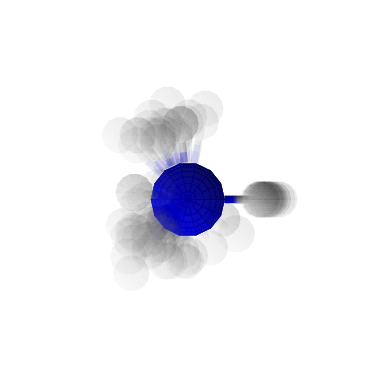

In [38]:
render_overlayed_systems(
    pbmetad_configs_monomer,
    centerer=lambda system: system.atoms[0].point,
    aligner=lambda system: (system.atoms[1].point, system.atoms[2].point),
    alpha=0.05,
    num_to_show=25
)

## Dimer

In [39]:
bond_params, angle_params, nonbonded_params = get_pbmetad_parameters(
        optimized_dimer
)

In [40]:
charges["E"] = 0.0
charges["F"] = 0.0

In [41]:
pbmetad_2b_size = 500

In [42]:
perform_pbmetad_simulation(
        "/expanse/projects/qstore/csd973/LAMMPS+plumed/LAMMPS-stable/bin/lmp_mpi",
        [optimized_monomer, optimized_water],
        num_configs=pbmetad_2b_size,
        sample_interval=10,
        temperature=700,
        seed=12345,
        configurations_path=structures.file("pbmetad_2b_traj.xyz"),
        bond_params=bond_params,
        angle_params=angle_params,
        nonbonded_params=nonbonded_params,
        charges=charges,
        pbmetad_workdir=scratch.sub_directory("pbmetad_2b_scratch"),
        restart_path=restart.file("pbmetad_2b_restart")
)

Preparing PBMetaD Simulation...
Running PBMetaD Simulation...
Converting PBMetaD trajectory to XYZ...


In [43]:
pbmetad_configs_dimer = perform_fps(
        definition_dimer,
        optimized_dimer,
        modes_dimer,
        structures.file("pbmetad_2b_traj.xyz"),
        num_pool_configs=pbmetad_2b_size,
        # num_phase1_input_configs=100000,
        # approx_configs_to_select=1000,
        num_phase1_input_configs=250,
        approx_configs_to_select=100,
        fps_workdir=scratch.sub_directory("fps_2b_scratch"),
        restart_path=restart.sub_directory("fps_2b_restart"),
        num_threads=16
)

Number of permutations: 48
Beginning featurization...
Featurization progress: |====================================================================================================| - 250/250
Featurized 250 configurations.
Initializing round 1 FPS...
BallTree built!
Performing round 1 FPS...
Round 1 FPS iterations: |====================================================================================================| - 100/100
Completed round 1 fps, selected 100 configs, max distance: 1.6669125023381473
Number of permutations: 48
Beginning featurization...
Featurization progress: |====================================================================================================| - 250/250
Featurized 250 configurations.
Initializing round 2 FPS...
BallTree built!
Performing round 2 FPS...
Round 2 FPS iterations: 22
Completed round 2 fps, selected 22 configs.
Selected 122 total configs by FPS.


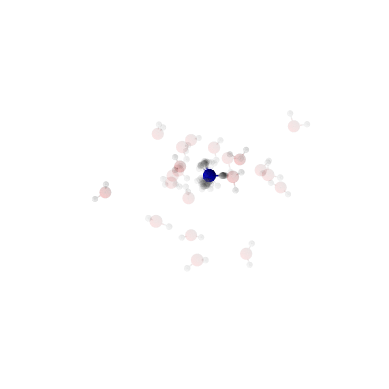

In [44]:
render_overlayed_systems(
    pbmetad_configs_dimer,
    centerer=lambda system: system.atoms[0].point,
    aligner=lambda system: (system.atoms[1].point, system.atoms[2].point),
    alpha=0.05,
    num_to_show=25
)

## Trimer

In [58]:
bond_params, angle_params, nonbonded_params = get_pbmetad_parameters(
        optimized_trimer
)

In [59]:
pbmetad_3b_size = 500

In [60]:
perform_pbmetad_simulation(
        "/expanse/projects/qstore/csd973/LAMMPS+plumed/LAMMPS-stable/bin/lmp_mpi",
        [optimized_monomer, optimized_water, optimized_water],
        num_configs=pbmetad_3b_size,
        sample_interval=10,
        temperature=700,
        seed=12345,
        configurations_path=structures.file("pbmetad_3b_traj.xyz"),
        bond_params=bond_params,
        angle_params=angle_params,
        nonbonded_params=nonbonded_params,
        charges=charges,
        pbmetad_workdir=scratch.sub_directory("pbmetad_3b_scratch"),
        restart_path=restart.file("pbmetad_3b_restart")
)

PBMetaD already completed. Will not rerun!


In [63]:
pbmetad_configs_trimer = perform_fps(
        definition_trimer,
        optimized_trimer,
        modes_trimer,
        structures.file("pbmetad_3b_traj.xyz"),
        num_pool_configs=pbmetad_3b_size,
        # num_phase1_input_configs=100000,
        # approx_configs_to_select=1000,
        num_phase1_input_configs=250,
        approx_configs_to_select=100,
        fps_workdir=scratch.sub_directory("fps_3b_scratch"),
        restart_path=restart.sub_directory("fps_3b_restart"),
        num_threads=16
)

Phase1 already complete. Will not rerun.
Phase2 already complete. Will not rerun.
Selected 111 total configs by FPS.


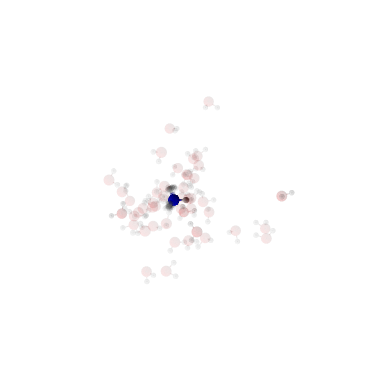

In [64]:
render_overlayed_systems(
    pbmetad_configs_trimer,
    centerer=lambda system: system.atoms[0].point,
    aligner=lambda system: (system.atoms[1].point, system.atoms[2].point),
    alpha=0.05,
    num_to_show=25
)